In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '../')
import read_stuff as read
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_3145122/698028492.py:19: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
class OptimMLR_all_2D(torch.nn.Module):
    def __init__(self):
        super(OptimMLR_all_2D, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [26*2,18*2,48+12,14*2,6*3,30,30]#9*2,6*3,30,30]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        self.dense5 = torch.nn.Linear(brchsize[4], 1)
        self.dense6 = torch.nn.Linear(brchsize[5], 1)
        self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(7,106)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,26*2,18*2,48+12,14*2,6*3,30,30]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestv = self.dense2(X_v)
        bestw = self.dense3(X_w)
        bestth = self.dense4(X_th)
        besthdia = self.dense5(X_hdia)
        bestlw = self.dense6(X_lw)
        bestsw = self.dense7(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestv,bestw,bestth,besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

In [16]:
import importlib
importlib.reload(read)

<module 'read_stuff' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/analysis/../read_stuff.py'>

In [48]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading input and outpus                    
└──────────────────────────────────────────────────────────────────────────"""
Xtrain_sd,Xvalid_sd,Xtest_sd,yall,yall_orig = read.train_optimizedMLR(folderpath,folderpath2,'decomp/standard/','rh').read_Xy(num=33)
Xtrain_mn,Xvalid_mn,Xtest_mn,yall,yall_orig = read.train_optimizedMLR(folderpath,folderpath2,'decomp/mean/','rh').read_Xy(num=33)
Xtrain,Xvalid,Xtest,yall,yall_orig = read.train_optimizedMLR(folderpath,folderpath2,'rh','rh').read_Xy(num=33)
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading PC structures for custom loss                       
└──────────────────────────────────────────────────────────────────────────"""
pcastore = read.train_optimizedMLR(folderpath,folderpath2,'rh').pcastore
#wcomps = [26,18,48,14]
wcomps = [26*2,18*2,48+12,14*2]
upcs,vpcs,wpcs,thpcs = pcastore['u'].components_[:wcomps[0]],pcastore['v'].components_[:wcomps[1]],pcastore['w'].components_[:wcomps[2]],pcastore['theta'].components_[:wcomps[3]]
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading y truth for custom loss                      
└──────────────────────────────────────────────────────────────────────────"""
yTRUTH = read.train_optimizedMLR(folderpath,folderpath2,'rh').y_truth(divider=divider,lti=24,num=33)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [18]:
import analysis

In [12]:
lti=24
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/'
model_c3 = read_and_proc.depickle(folderpath+'/output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/FFWmodels_cross7_0_33')
new_feature_c3 = read_and_proc.depickle(folderpath+'/output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/newfeature_cross7_0_33')
reducedX_c3 = read_and_proc.depickle(folderpath+'/output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/reducedX_cross7_0_33')
haiyanmodelsDICT = {'model':model_c3,'newfeature':new_feature_c3,'reducedX':reducedX_c3}
del model_c3,new_feature_c3,reducedX_c3
gc.collect()

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
Xtest_orig,Xtrain_orig,Xvalid_orig = [],[],[]

for i in tqdm(range(33)):
    temp1,temp2,temp3,temp4 = analysis.real_random(i,3,folderpath)
    Xtest_orig.append(temp1)
    Xtrain_orig.append(temp2)
    Xvalid_orig.append(temp3)
    
from tools.validation import r2_analysis
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
dict1 = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g')
haiyan_data = read_and_proc.depickle(folderpath+'pca/flatvar'+'_'+'dict2_g')

orig_testY = r2_analysis._get_r2(dict1,haiyan_data,[26,18,48,14],24,haiyanmodelsDICT['model'],haiyanmodelsDICT['reducedX'],None,'Haiyan_axisym')._get_testX(Xtest_orig,yall_orig,[121,122,123,124],haiyanmodelsDICT['newfeature'])

  0%|          | 0/33 [00:00<?, ?it/s]

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator IncrementalPCA from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


  0%|          | 0/33 [00:00<?, ?it/s]

In [21]:
import glob
def output_processed(Xtrain=None,Xvalid=None,Xtest=None,yall=None,folderpath=None,folderpath2=None,splitnum=None):
    """──────────────────────────────────────────────────────────────────────────┐
    │ Which split will we be testing                     
    └──────────────────────────────────────────────────────────────────────────"""
    splitnum = splitnum
    """──────────────────────────────────────────────────────────────────────────┐
    │ Remove zero values                    
    └──────────────────────────────────────────────────────────────────────────"""
    X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2,'decomp/standard/','rh').delete_padding(Xtrain[splitnum]['lwswdtthuvw'],yall[splitnum][23][0])
    X_tovalid,y_tovalid = read.train_optimizedMLR(folderpath,folderpath2,'decomp/standard/','rh').delete_padding(Xvalid[splitnum]['lwswdtthuvw'],yall[splitnum][23][1])
    X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2,'decomp/standard/','rh').delete_padding(Xtest[splitnum]['lwswdtthuvw'],yall[splitnum][23][2])
    
    calc_device = 'cpu'
    ###################################################################################
    # Convert numpy arrays into tensors
    ###################################################################################
    train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
    train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
    val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
    val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
    test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
    test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
    train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
    val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
    test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
    
    modelpaths = sorted(glob.glob('../tmp/torch_try/1108/'+str(splitnum)+'/models*'))
    model = [torch.load(obj) for obj in modelpaths]
    
    return {'train':train_Xtensor,'val':val_Xtensor,'test':test_Xtensor},{'train':train_ytensor,'val':val_ytensor,'test':test_ytensor},{'train':train_data,'val':val_data,'test':test_data},model

In [46]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
Xtensor,ytensor,data,models = output_processed(Xtrain,Xvalid,Xtest,yall,folderpath,folderpath2,0)

In [29]:
list(np.asarray([0,26*2,18*2,48+12,14*2,6*3,30,30]).cumsum())

[0, 52, 88, 148, 176, 194, 224, 254]

In [49]:
import pandas as pd
allmodels = []
Xtensors_sd = []
ytensors_sd = []
Xtensors_mn = []
ytensors_mn = []
Xtensors = []
ytensors = []

for split in tqdm(range(33)):
    folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
    folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
    Xtensor,ytensor,data,models = output_processed(Xtrain,Xvalid,Xtest_sd,yall,folderpath,folderpath2,split)
    Xtensor_sd,ytensor_sd,data,models = output_processed(Xtrain_sd,Xvalid_sd,Xtest_sd,yall,folderpath,folderpath2,split)
    Xtensor_mn,ytensor_mn,data,models = output_processed(Xtrain_mn,Xvalid_mn,Xtest_mn,yall,folderpath,folderpath2,split)
    xgmodl = []
    for i in range(len(models)):
        xgmodl.append(models[i])
    allmodels.append(xgmodl)
    Xtensors_sd.append(Xtensor_sd)
    ytensors_sd.append(ytensor_sd)
    Xtensors_mn.append(Xtensor_mn)
    ytensors_mn.append(ytensor_mn)
    Xtensors.append(Xtensor)
    ytensors.append(ytensor)

  0%|          | 0/33 [00:00<?, ?it/s]

In [88]:
tensors_to_test = Xtensors[0]['test'].data.numpy().copy()
Xtestdemp = np.zeros_like(tensors_to_test)
Xtestdemp[:,224:254] = Xtensors[0]['test'].data.numpy()[:,224:254]

In [25]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [40]:
def give_pred(pcastore=None,model=None,splitnum=30,tensor_topred=None):
    bbbbbb_th = np.dot(model(tensor_topred).detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
    bbbbbb_w = np.dot(model(tensor_topred).detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
    bbbbbb_v = np.dot(model(tensor_topred).detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
    bbbbbb_u = np.dot(model(tensor_topred).detach().numpy()[:,:26],pcastore['u'].components_[:26])
    return {'u':bbbbbb_u,'v':bbbbbb_v,'w':bbbbbb_w,'theta':bbbbbb_th}

def _give_pred_decomp(Xtensor=None,model=None,indx=[0,52],pcastore=None):
    Xdemp = np.zeros_like(Xtensor)
    Xdemp[:,indx[0]:indx[1]] = Xtensor.data.numpy()[:,indx[0]:indx[1]]
    return give_pred(pcastore, model, 30, torch.FloatTensor(Xdemp).to('cpu'))

In [147]:
TYPES = 'train'
mndlindx = 20 #13
upred_mn = _give_pred_decomp(Xtensors_mn[0][TYPES],flatten(allmodels)[mndlindx][0],[0,52],pcastore)#give_pred(pcastore, flatten(allmodels)[13][0], 30, torch.FloatTensor(Xtestdemp).to('cpu'))
vpred_mn = _give_pred_decomp(Xtensors_mn[0][TYPES],flatten(allmodels)[mndlindx][0],[52,88],pcastore)
wpred_mn = _give_pred_decomp(Xtensors_mn[0][TYPES],flatten(allmodels)[mndlindx][0],[88,148],pcastore)
thetapred_mn = _give_pred_decomp(Xtensors_mn[0][TYPES],flatten(allmodels)[mndlindx][0],[148,176],pcastore)
hdiapred_mn = _give_pred_decomp(Xtensors_mn[0][TYPES],flatten(allmodels)[mndlindx][0],[176,194],pcastore)
lwpred_mn = _give_pred_decomp(Xtensors_mn[0][TYPES],flatten(allmodels)[mndlindx][0],[194,224],pcastore)
swpred_mn = _give_pred_decomp(Xtensors_mn[0][TYPES],flatten(allmodels)[mndlindx][0],[224,254],pcastore)

upred_sd = _give_pred_decomp(Xtensors_sd[0][TYPES],flatten(allmodels)[mndlindx][0],[0,52],pcastore)#give_pred(pcastore, flatten(allmodels)[13][0], 30, torch.FloatTensor(Xtestdemp).to('cpu'))
vpred_sd = _give_pred_decomp(Xtensors_sd[0][TYPES],flatten(allmodels)[mndlindx][0],[52,88],pcastore)
wpred_sd = _give_pred_decomp(Xtensors_sd[0][TYPES],flatten(allmodels)[mndlindx][0],[88,148],pcastore)
thetapred_sd = _give_pred_decomp(Xtensors_sd[0][TYPES],flatten(allmodels)[mndlindx][0],[148,176],pcastore)
hdiapred_sd = _give_pred_decomp(Xtensors_sd[0][TYPES],flatten(allmodels)[mndlindx][0],[176,194],pcastore)
lwpred_sd = _give_pred_decomp(Xtensors_sd[0][TYPES],flatten(allmodels)[mndlindx][0],[194,224],pcastore)
swpred_sd = _give_pred_decomp(Xtensors_sd[0][TYPES],flatten(allmodels)[mndlindx][0],[224,254],pcastore)

tensors_to_test = Xtensors[0][TYPES].data.numpy().copy()
Xtestdemp = np.zeros_like(tensors_to_test)
#Xtestdemp[:,224:254] = Xtensors[0]['test'].data.numpy()[:,224:254]
bpred = give_pred(pcastore, flatten(allmodels)[mndlindx][0], 30, torch.FloatTensor(Xtestdemp).to('cpu'))

tensors_to_test = Xtensors[0][TYPES].data.numpy().copy()
Xtestdemp = np.zeros_like(tensors_to_test)
#Xtestdemp[:,224:254] = Xtensors[0]['test'].data.numpy()[:,224:254]
allpred = give_pred(pcastore, flatten(allmodels)[mndlindx][0], 30, torch.FloatTensor(tensors_to_test).to('cpu'))

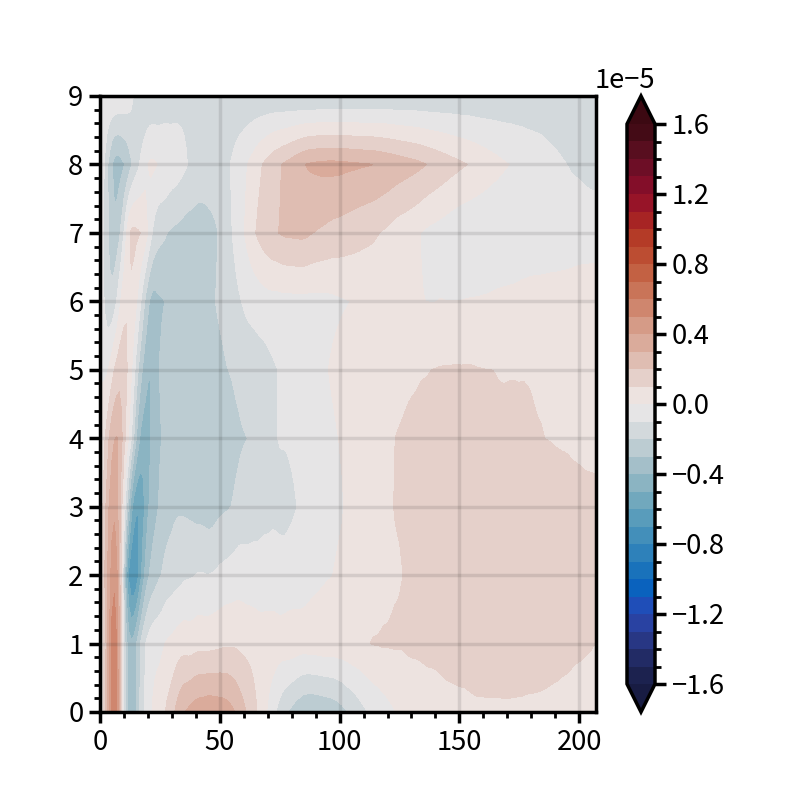

In [101]:
#plt.contourf(lwpred['v'].reshape(-1,10,208)[40,...],cmap='balance',levels=np.linspace(-8e-5,8e-5,33))
plt.contourf(lwpred_sd['v'].reshape(-1,10,208)[60,...]-lwpred_mn['v'].reshape(-1,10,208)[60,...],cmap='balance',levels=np.linspace(-16e-6,16e-6,33),extend='both')
plt.colorbar()
plt.show()

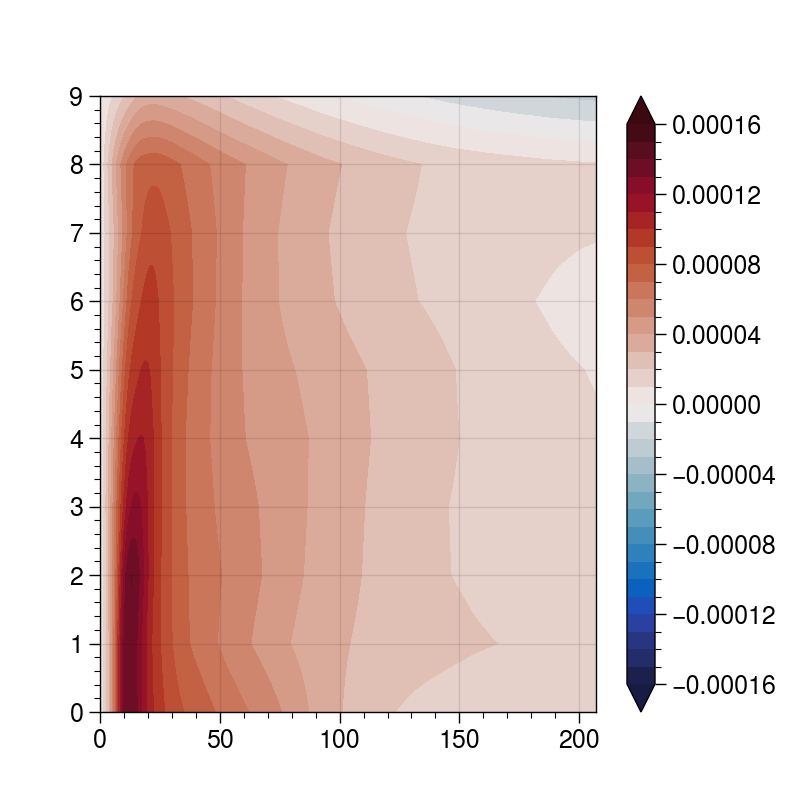

In [98]:
#plt.contourf(lwpred['v'].reshape(-1,10,208)[40,...],cmap='balance',levels=np.linspace(-8e-5,8e-5,33))
plt.contourf(swpred['v'].reshape(-1,10,208)[10,...],cmap='balance',levels=np.linspace(-16e-5,16e-5,33),extend='both')
plt.colorbar()
plt.show()

/tmp/ipykernel_3145122/1898180482.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


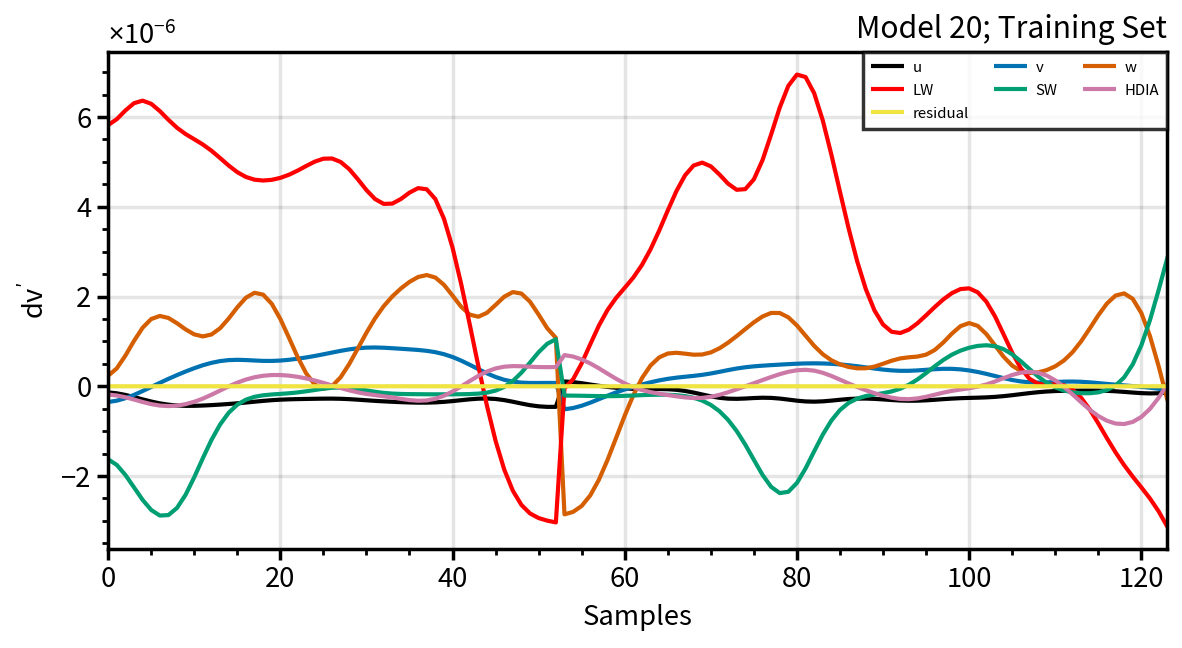

In [146]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

vertlv,outextent=2,67
allss = np.mean(allpred['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)
asll = np.mean(upred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+\
               np.mean(vpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(wpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+\
np.mean(lwpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(swpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(hdiapred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(thetapred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)

asll_mn = np.mean(upred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+\
               np.mean(vpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(wpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+\
np.mean(lwpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(swpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(hdiapred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(thetapred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)

indx=0
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=5.295,refaspect=2.131)
#axs.plot(np.mean(upred['v'].reshape(-1,10,208)[:,0,:],axis=1),label='u',c='k')
axs.plot(np.mean(upred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(upred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='u',c='k')
axs.plot(np.mean(vpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(vpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='v')
axs.plot(np.mean(wpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(wpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='w')
axs.plot(np.mean(lwpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(lwpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='LW',c='r')
axs.plot(np.mean(swpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(swpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='SW')
axs.plot(np.mean(hdiapred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(hdiapred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='HDIA')

#axs.plot(np.mean(vpred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='v_mn',ls='--')
#axs.plot(np.mean(wpred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='w_mn',ls='--')
#axs.plot(np.mean(lwpred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='LW_mn',c='r',ls='--')
#axs.plot(np.mean(swpred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='SW_mn',ls='--')
#axs.plot(np.mean(hdiapred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='hdia_mn',ls='--')
#axs.plot(allss-np.mean(upred['v'].reshape(-1,10,208)[:,0,:],axis=1),label='allss')
axs.plot(allss-asll+asll_mn-np.mean(bpred['v'].reshape(-1,10,208)[:,2,:67],axis=1),label='residual')
#axs.plot(asll_mn,label='mn')
#axs.plot(np.mean(bpred['v'].reshape(-1,10,208)[:,0,:],axis=1),label='Intercept')
axs.legend(prop={'size':6})
axs.format(rtitle='Model 20; Training Set',xlabel='Samples',ylabel='dv$^{\prime}$')
plt.savefig('./pic/1114/bestmodel2_decomps_test.png',dpi=400)
plt.show()

/tmp/ipykernel_3145122/4001521740.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


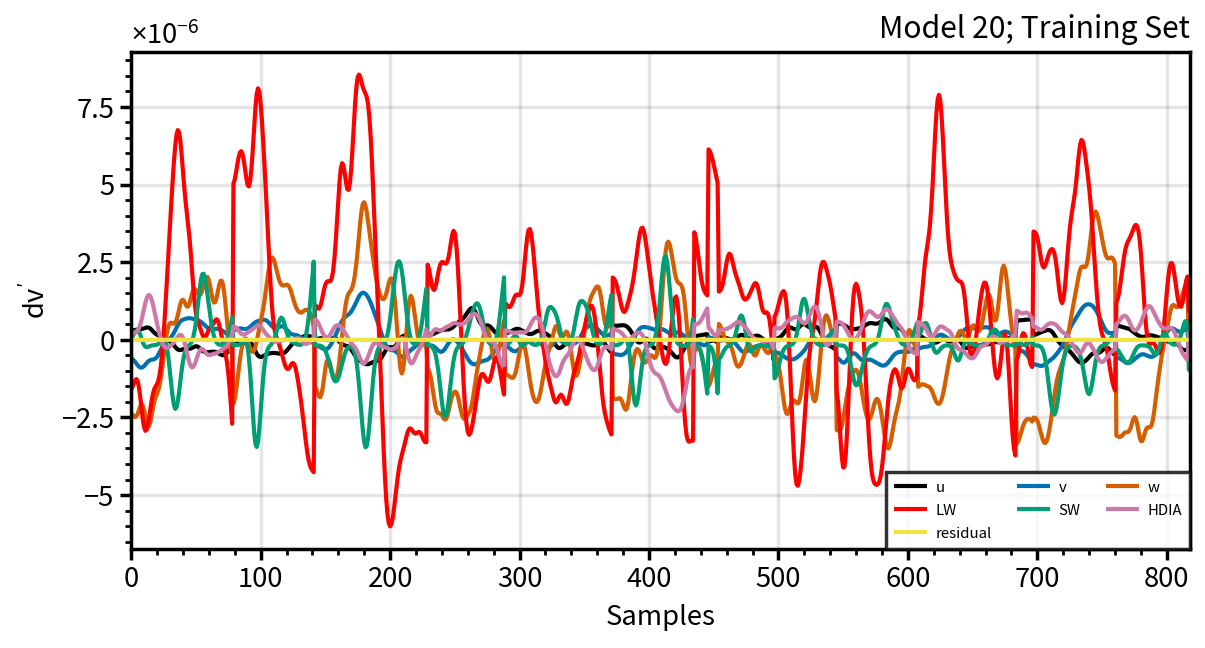

In [148]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

vertlv,outextent=2,67
allss = np.mean(allpred['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)
asll = np.mean(upred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+\
               np.mean(vpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(wpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+\
np.mean(lwpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(swpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(hdiapred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(thetapred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)

asll_mn = np.mean(upred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+\
               np.mean(vpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(wpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+\
np.mean(lwpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(swpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(hdiapred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)+np.mean(thetapred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)

indx=0
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=5.295,refaspect=2.131)
#axs.plot(np.mean(upred['v'].reshape(-1,10,208)[:,0,:],axis=1),label='u',c='k')
axs.plot(np.mean(upred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(upred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='u',c='k')
axs.plot(np.mean(vpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(vpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='v')
axs.plot(np.mean(wpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(wpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='w')
axs.plot(np.mean(lwpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(lwpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='LW',c='r')
axs.plot(np.mean(swpred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(swpred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='SW')
axs.plot(np.mean(hdiapred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(hdiapred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='HDIA')
#axs.plot(np.mean(thetapred_sd['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1)-np.mean(thetapred_mn['v'].reshape(-1,10,208)[:,vertlv,:outextent],axis=1),label='THETA')

#axs.plot(np.mean(vpred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='v_mn',ls='--')
#axs.plot(np.mean(wpred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='w_mn',ls='--')
#axs.plot(np.mean(lwpred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='LW_mn',c='r',ls='--')
#axs.plot(np.mean(swpred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='SW_mn',ls='--')
#axs.plot(np.mean(hdiapred_mn['v'].reshape(-1,10,208)[:,0,:],axis=1),label='hdia_mn',ls='--')
#axs.plot(allss-np.mean(upred['v'].reshape(-1,10,208)[:,0,:],axis=1),label='allss')
axs.plot(allss-asll+asll_mn-np.mean(bpred['v'].reshape(-1,10,208)[:,2,:67],axis=1),label='residual')
#axs.plot(asll_mn,label='mn')
#axs.plot(np.mean(bpred['v'].reshape(-1,10,208)[:,0,:],axis=1),label='Intercept')
axs.legend(prop={'size':6})
axs.format(rtitle='Model 20; Training Set',xlabel='Samples',ylabel='dv$^{\prime}$')
plt.savefig('./pic/1114/bestmodel2_decomps_train.png',dpi=400)
plt.show()

In [115]:
len(flatten(allmodels))

250